Notebook to compare nowcast vs nowcast green along thalweg

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np

from salishsea_tools import visualisations as vis
from salishsea_tools import (teos_tools, tidetools)

%matplotlib inline

In [2]:
def results_dataset(results_dir, date, period, grid_type):
    datestr = date.strftime('%Y%m%d')
    subdir = date.strftime('%d%b%y').lower()
    fname = os.path.join(results_dir, subdir,
                        'SalishSea_{}_{}_{}_{}.nc'.format(period, datestr, datestr, grid_type))
    grid = nc.Dataset(fname)
    return grid

In [3]:
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
mesh_mask_green = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_downbyone.nc')

grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
grid_B_green = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_downonegrid.nc')


# Compare nowcast and nowcast-green

## Testing that plotting routines work with downbyone

Feb 7, 2016 comparison

In [4]:
nowcast = '/results/SalishSea/nowcast/'
nowcast_green = '/results/SalishSea/nowcast-green/'
date = datetime.datetime(2016, 2, 7)
grid_T = results_dataset(nowcast, date, '1d', 'grid_T')
grid_T_green = results_dataset(nowcast_green, date, '1d', 'grid_T')

In [5]:
grids = {'nowcast': {'data': grid_T,
                     'bathy': grid_B,
                     'mesh': mesh_mask,
                     'depname': 'gdept',
                     'dep1D': 'gdept_0'},
        'nowcast-green': {'data': grid_T_green,
                          'bathy': grid_B_green,
                          'mesh': mesh_mask_green,
                          'depname':'gdept_0',
                          'dep1D': 'gdept_1d'},
         }

In [6]:
def compare_thalweg(grids, date, var_name):
    
    mapping_dict = {'salinity': {'label': 'Salinity [g/kg]',
                                 'model_var': 'vosaline',
                                 'psu_tools': True,
                                 'cmap': 'hsv',
                                 'xcoord_distance': True,
                                 '3d_depth': True},
                    'temperature': {'label': 'Temperature [deg C]',
                                    'model_var': 'votemper',
                                    'psu_tools': False,
                                    'cmap': 'jet',
                                    'xcoord_distance': False,
                                    '3d_depth': False}}
    
    ps = mapping_dict[var_name]
    fig, axs = plt.subplots(2,1,figsize=(15,8))

    for ax, key in zip(axs, grids):
        # prepare for plotting
        if var_name == 'salinity':
            if key=='nowcast-green':
                ps['psu_tools'] = False
            else:
                ps['psu_tools'] = True
        grid = grids[key]
        bathy, X, Y = tidetools.get_bathy_data(grid['bathy'])
        var = grid['data'].variables[ps['model_var']][:]
        tmask = grid['mesh'].variables['tmask'][:] + np.zeros(var.shape)
        var_mask = np.ma.array(var, mask = 1-tmask)
        if ps['psu_tools']:
            var_plot = teos_tools.psu_teos(var_mask[0,:,:,:])
        else:
            var_plot = var_mask[0,:,:,:]
        if ps['3d_depth']:
            dp = 'depname'
        else:
            dp='dep1D'
        
        ###### plot
        cbar = vis.contour_thalweg(ax, var_plot, bathy, X, Y, grid['mesh'], grid[dp], var_name, 
                                   cmap=ps['cmap']  )
       
        # pretty the plots
        ax.set_title('{} {} {}'.format(key, var_name, date.strftime('%d-%b-%Y')))
        cbar.set_label(ps['label'])
        
        ax.set_ylim([450,0])


## Salinity, full depth arrays, distance along thalweg

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


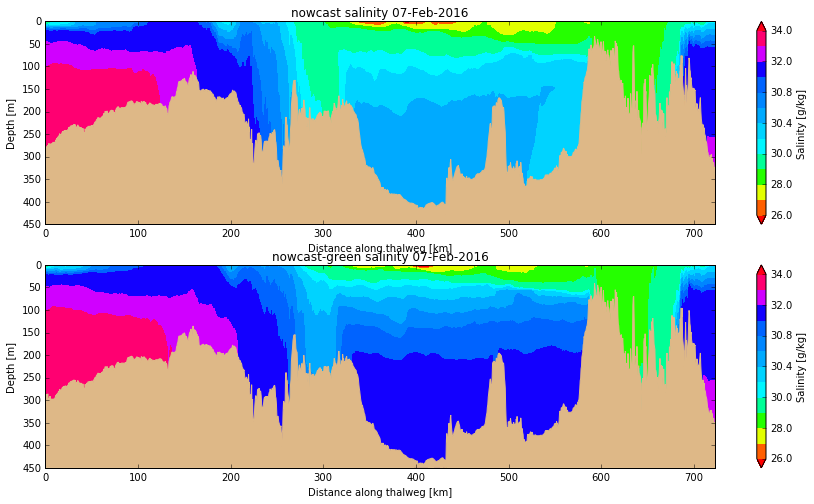

In [7]:
compare_thalweg(grids, date, 'salinity')

## Temperature, 1D depth arrays, thalweg index

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


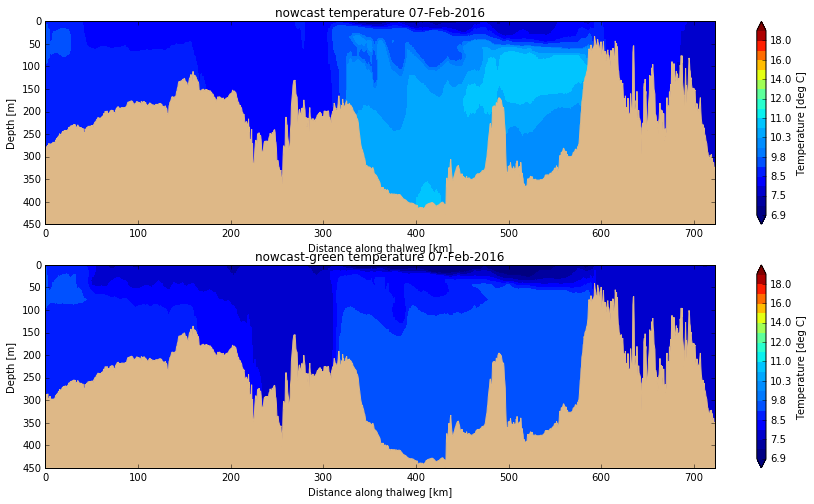

In [8]:
 compare_thalweg(grids, date, 'temperature')

# Recent comparison

In [9]:
date = datetime.datetime(2016, 6, 5)
grid_T = results_dataset(nowcast, date, '1d', 'grid_T')
grid_T_green = results_dataset(nowcast_green, date, '1d', 'grid_T')


grids = {'nowcast': {'data': grid_T,
                     'bathy': grid_B,
                     'mesh': mesh_mask,
                     'depname': 'gdept',
                     'dep1D': 'gdept_0'},
        'nowcast-green': {'data': grid_T_green,
                          'bathy': grid_B_green,
                          'mesh': mesh_mask_green,
                          'depname':'gdept_0',
                          'dep1D': 'gdept_1d'},
         }

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


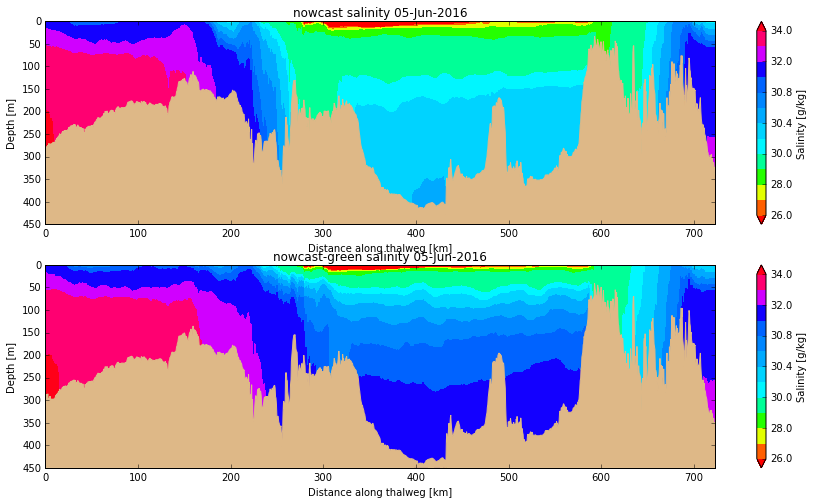

In [10]:
compare_thalweg(grids, date, 'salinity')

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


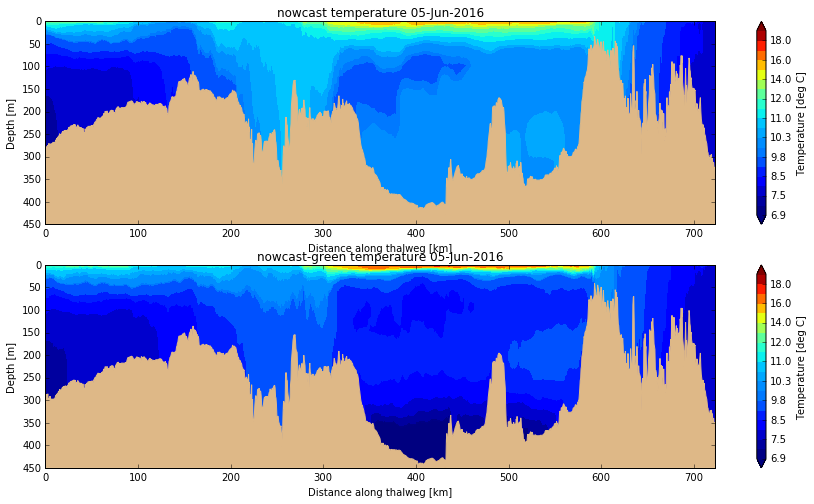

In [11]:
compare_thalweg(grids, date, 'temperature')

In [12]:
def compare_surface_temperature(grids, date):
    
    fig, axs = plt.subplots(1,2,figsize=(15,8))
    clevels = [0,1,2,3,4,5,6, 7, 7.5, 8, 8.5, 9, 9.8, 9.9, 10.3, 10.5, 11, 11.5, 12, 13, 14, 15, 16, 17, 18, 19, 20]

    for ax, key in zip(axs, grids):
        # prepare for plotting
        grid = grids[key]
        temp = grid['data'].variables['votemper'][:]
        tmask = grid['mesh'].variables['tmask'][:] + np.zeros(temp.shape)
        temp_mask = np.ma.array(temp, mask = 1-tmask)
        
        mesh  = ax.contourf(temp_mask[0,0,:,:], clevels, extend='both', corner_mask=True)
        
        # pretty the plots
        ax.set_title('{} Temperature {}'.format(key, date.strftime('%d-%b-%Y')))
        cbar = plt.colorbar(mesh, ax=ax)
        cbar.set_label('Temperature [deg C]')
        

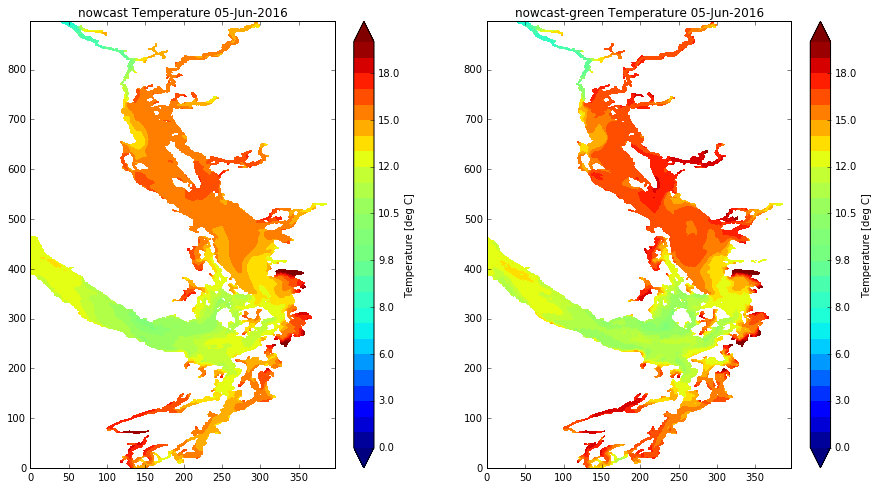

In [13]:
 compare_surface_temperature(grids, date)

In [14]:
def compare_surface_salinity(grids, date):
    
    fig, axs = plt.subplots(1,2,figsize=(15,8))
    clevels = np.arange(0,34)

    for ax, key in zip(axs, grids):
        # prepare for plotting
        grid = grids[key]
        sal = grid['data'].variables['vosaline'][:]
        tmask = grid['mesh'].variables['tmask'][:] + np.zeros(sal.shape)
        sal_mask = np.ma.array(sal, mask = 1-tmask)
        if key != 'nowcast-green':
            sal_mask = teos_tools.psu_teos(sal_mask)
            print ('{} to teos'.format(key))
        
        mesh  = ax.contourf(sal_mask[0,0,:,:], clevels, extend='both')
        
        # pretty the plots
        ax.set_title('{} Salinity {}'.format(key, date.strftime('%d-%b-%Y')))
        cbar = plt.colorbar(mesh, ax=ax)
        cbar.set_label('Salinity [g/kg]')
        


nowcast to teos


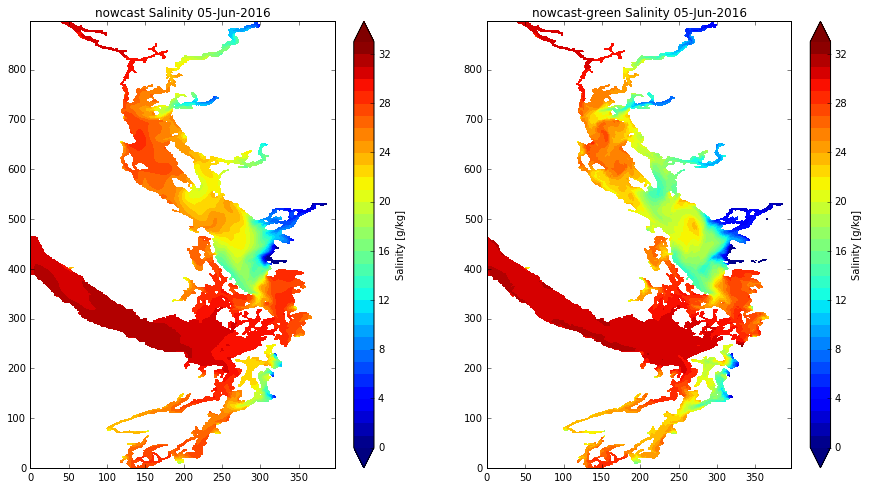

In [15]:
 compare_surface_salinity(grids, date)